In [ ]:
from google.colab import files

files.upload()

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ronanpickell/b200c-lego-classification-dataset
!unzip b200c-lego-classification-dataset.zip
!rm b200c-lego-classification-dataset.zip

In [3]:
import os
from pathlib import Path

data_path = Path("64")

def walk_dir(dir):
    for dirpath, dirnames, filenames in os.walk(dir):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

walk_dir(data_path)

There are 200 directories and 0 images in 64
There are 0 directories and 4000 images in 64/28192
There are 0 directories and 4000 images in 64/63864
There are 0 directories and 4000 images in 64/30413
There are 0 directories and 4000 images in 64/85861
There are 0 directories and 4000 images in 64/14704
There are 0 directories and 4000 images in 64/26601
There are 0 directories and 4000 images in 64/3069b
There are 0 directories and 4000 images in 64/4865
There are 0 directories and 4000 images in 64/2420
There are 0 directories and 4000 images in 64/4274
There are 0 directories and 4000 images in 64/3031
There are 0 directories and 4000 images in 64/48729
There are 0 directories and 4000 images in 64/4589
There are 0 directories and 4000 images in 64/24246
There are 0 directories and 4000 images in 64/43093
There are 0 directories and 4000 images in 64/3665
There are 0 directories and 4000 images in 64/3070b
There are 0 directories and 4000 images in 64/3673
There are 0 directories an

In [4]:
!mkdir sub-64

In [5]:
from random import sample

num_classes=25

dir_list = os.listdir(data_path)
sample_dir = sample(dir_list, num_classes)
for dir in sample_dir:
    os.system(f"cp -R 64/{dir} sub-64/{dir}")

sub_data_path = Path("sub-64")
walk_dir(sub_data_path)

There are 25 directories and 0 images in sub-64
There are 0 directories and 4000 images in sub-64/85861
There are 0 directories and 4000 images in sub-64/3070b
There are 0 directories and 4000 images in sub-64/62462
There are 0 directories and 4000 images in sub-64/4599b
There are 0 directories and 4000 images in sub-64/3832
There are 0 directories and 4000 images in sub-64/15535
There are 0 directories and 4000 images in sub-64/27925
There are 0 directories and 4000 images in sub-64/41740
There are 0 directories and 4000 images in sub-64/60478
There are 0 directories and 4000 images in sub-64/99563
There are 0 directories and 4000 images in sub-64/3035
There are 0 directories and 4000 images in sub-64/4073
There are 0 directories and 4000 images in sub-64/61678
There are 0 directories and 4000 images in sub-64/11476
There are 0 directories and 4000 images in sub-64/32000
There are 0 directories and 4000 images in sub-64/35480
There are 0 directories and 4000 images in sub-64/14719
The

In [6]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
from torchvision import datasets, transforms

dataset = datasets.ImageFolder(root=sub_data_path, transform=transforms.ToTensor())
dataset

Dataset ImageFolder
    Number of datapoints: 100000
    Root location: sub-64
    StandardTransform
Transform: ToTensor()

In [8]:
from torch.utils.data import random_split, DataLoader

In [ ]:
train_dataset, test_dataset = random_split(dataset, (num_classes*3200, num_classes*800))

train_dataloader = DataLoader(train_dataset, 256, shuffle=True)
test_dataloader = DataLoader(test_dataset, 256, shuffle=False)

In [11]:
from torch import nn

class TinyVGG(nn.Module):
    def __init__(self, input: int, hidden: int, output: int) -> None:
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(
                in_channels = input,
                out_channels = hidden,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels = hidden,
                out_channels = hidden,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2,
                ),
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(
                in_channels = hidden,
                out_channels = hidden,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels = hidden,
                out_channels = hidden,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2,
                ),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=hidden*16*16, 
                out_features=output,
                ),
        )

    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block2(self.conv_block1(x)))

model = TinyVGG(3, 10, num_classes).to(device)
model

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=25, bias=True)
  )
)

In [12]:
def train_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer):
    
    model.train()
    train_loss, train_acc = 0, 0

    for X, y in dataloader:

        X, y = X.to(device), y.to(device)

        pred = model(X)

        loss = loss_fn(pred, y)
        train_loss+=loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred_class = torch.argmax(torch.softmax(pred, dim=1), dim=1)
        train_acc += (pred_class==y).sum().item()/len(pred_class)
    
    train_loss = train_loss/len(dataloader)    
    train_acc = train_acc/len(dataloader)  
    return train_loss, train_acc

In [13]:
def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():

        for X, y in dataloader:

            X, y = X.to(device), y.to(device)

            pred = model(X)

            loss = loss_fn(pred, y)
            test_loss+=loss.item()

            pred_class = torch.argmax(torch.softmax(pred, dim=1), dim=1)
            test_acc+= (pred_class==y).sum().item()/len(pred_class)

    test_loss = test_loss/len(dataloader)    
    test_acc = test_acc/len(dataloader)   
    return test_loss, test_acc

In [14]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int = 5):
    
    results = {"train loss":[],
               "train acc":[],
               "test loss":[],
               "test acc":[]
               }
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, 
                                           train_dataloader, 
                                           loss_fn, 
                                           optimizer)
        test_loss, test_acc = test_step(model, 
                                        train_dataloader, 
                                        loss_fn)
        
        results["train loss"].append(train_loss)
        results["train acc"].append(train_acc)
        results["test loss"].append(test_loss)
        results["test acc"].append(test_acc)
    
    return results

In [15]:
from timeit import default_timer as timer

NUM_EPOCHS = 25

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

start = timer()

model_results = train(model,
                      train_dataloader,
                      test_dataloader,
                      loss_fn,
                      optimizer, 
                      NUM_EPOCHS)

end = timer()
print(f"training time: {end-start:.3f} seconds")

  0%|          | 0/25 [00:00<?, ?it/s]

training time: 1709.653 seconds


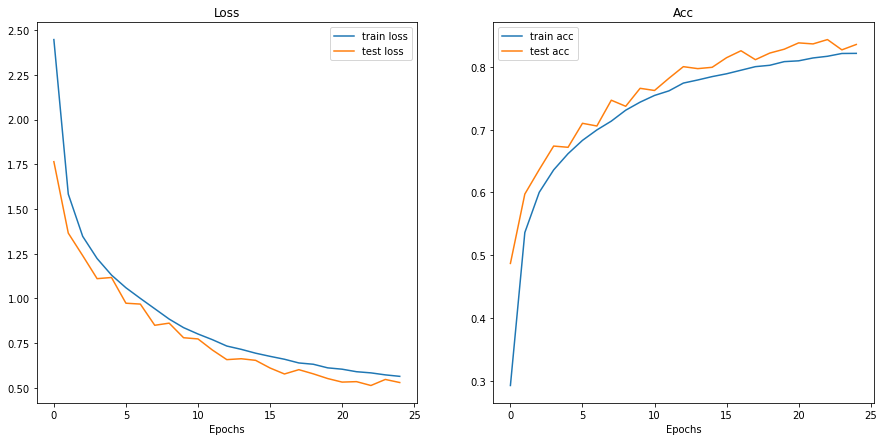

In [16]:
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):

    train_loss = results["train loss"]
    train_acc = results["train acc"]
    test_loss = results["test loss"]
    test_acc = results["test acc"]

    epochs = range(len(train_loss))

    plt.figure(figsize=(15,7))

    plt.subplot(1,2,1)
    plt.plot(epochs, train_loss, label="train loss")
    plt.plot(epochs, test_loss, label="test loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, train_acc, label="train acc")
    plt.plot(epochs, test_acc, label="test acc")
    plt.title("Acc")
    plt.xlabel("Epochs")
    plt.legend()

plot_loss_curves(model_results)